# Thermochemistry

In [1]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from scipy.optimize import root_scalar
from scipy import constants

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

# for convenience:
def to_si(quant):
    '''Converts a Pint Quantity to magnitude at base SI units.
    '''
    return quant.to_base_units().magnitude

In [2]:
# these lines are only for helping improve the display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
# define some constants
Ru = Q_(constants.R, 'J/(K*mol)')
g0 = Q_(constants.g, 'm/s^2')

The thermochemical performance of a rocket is primarily represented using the characteristic velocity:

$$
c^* = \frac{p_c A_t}{\dot{m}} = \sqrt{\frac{\mathcal{R}_u T_c}{\textrm{MW} \, \gamma} \left( \frac{\gamma + 1}{2} \right)^{\frac{\gamma+1}{\gamma-1}} } \;,
$$ (eq_cstar)

which depends on the (combustion) chamber temperature $T_c$, gas molecular weight $\textrm{MW}$, and gas specific heat ratio $\gamma$.
The thrust coefficient $C_F$ mainly represents the performance of the nozzle, but it also depends on the specific heat ratio $\gamma$.

Up to this point, we have been provided or assumed these values, but they are actually a function of

* propellant(s)
* ratio of oxidizer to fuel

Given a propellant or combination of propellants and heating (due to combustion, nuclear reactions, or electricity),
the gas in the chamber and moving into the nozzle will form a mixture of chemical species at the state of chemical equilibrium. At this state, the forward and reverse rates of all chemical reactions are balanced, and the species remain at a fixed composition (as long as the temperature and/or pressure remain constant).

The amounts of the chemical species at the equilibrium are unknown, but can be determined based on the initial conditions using methods based on [reaction equilibrium constants](https://kyleniemeyer.github.io/computational-thermo/content/chemical-equilibrium/equilibrium-constant.html) or the [minimization of Gibbs free energy](https://kyleniemeyer.github.io/computational-thermo/content/chemical-equilibrium/equilibrium-alternative-methods.html).
If the temperature is not known/fixed, then it is also an unknown and must be found.

Fortunately, we can use software tools such as NASA's [CEA](https://cearun.grc.nasa.gov) or [Cantera](https://cantera.org) to find the equilibrium state for us. We'll focus on CEA here.

In [29]:
def get_area_ratio(pressure_ratio, gamma):
    '''Calculates area ratio based on specific heat ratio and pressure ratio.
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return (
        np.power(2 / (gamma + 1), 1/(gamma-1)) * 
        np.power(pressure_ratio, 1 / gamma) *
        np.sqrt((gamma - 1) / (gamma + 1) /
                (1 - np.power(pressure_ratio, (1 - gamma)/gamma))
                )
        )

def root_area_ratio(pressure_ratio, area_ratio, gamma):
    ''' Returns zero for a given area ratio, pressure ratio, and gamma.
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return area_ratio - get_area_ratio(pressure_ratio, gamma)

def get_thrust_coeff(pressure_ratio, gamma):
    '''Calculates thrust coefficient for optimum expansion.
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return np.sqrt(
        2 * np.power(gamma, 2) / (gamma - 1) * 
        np.power(2 / (gamma + 1), (gamma + 1)/(gamma - 1)) * 
        (1 - np.power(1.0 / pressure_ratio, (gamma - 1)/gamma))
        )

def get_cstar(Tc, MW, gamma):
    '''Calculates cstar using chamber properties.'''
    return (
        np.sqrt(Ru * Tc / (gamma * MW)) * 
        (2 / (gamma + 1))**(-0.5*(gamma + 1)/(gamma - 1))
        )

## Fixed temperature and pressure

Let's first consider the problem where the pressure and temperature of the combustion/heating chamber are fixed and known, and determine the equilibrium composition of chemical species.
This problem is relevant to an isothermal process, or where temperature is a design variable, such
as in nuclear thermal or electrothermal rockets.

```{margin} CEA warning
When you are doing a problem in CEA involving a monopropellant, meaning without an oxidizer, you may run into an error on the website after entering `None` for the oxidizer. On that page, instead of clicking the "Accept" button, use the top navigation bar to go directly to the "Final" tab.
```

For example, say we have an arcjet operating on gaseous hydrazine (N<sub>2</sub>H<sub>4</sub>) 
as a propellant, with a chamber temperature of 5000 K and pressure of 50 psia. 
The nozzle area ratio is 100, and the arcjet will operate in vacuum.
For this system, determine the equilibrium composition, the average molecular weight, ratio of specific heats $\gamma$,
and then use these to get $c^*$, $C_F$, and $I_{\textrm{sp}}$.

In [CEA](https://cearun.grc.nasa.gov/), this is a `tp` problem, or fixed temperature and pressure problem.
We should expect that, at such high temperatures, the equilibrium state will have mostly one- and two-atom
molecules, based on the elements present: N<sub>2</sub>, H<sub>2</sub>, H, N, and HN.

The CEA plaintext input file looks like:

```text
prob tp
 
p,psia= 50  t,k= 5000

reac
name N2H4 mol 1.0

output siunits
end
```

and the output is (with the repeated input removed):

```text
*******************************************************************************

         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA2, FEBRUARY 5, 2004
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************

               THERMODYNAMIC EQUILIBRIUM PROPERTIES AT ASSIGNED

                           TEMPERATURE AND PRESSURE

             REACTANT                    WT FRACTION      ENERGY      TEMP
                                          (SEE NOTE)     KJ/KG-MOL      K  
 NAME        N2H4                         1.0000000         0.000      0.000

 O/F=    0.00000  %FUEL=  0.000000  R,EQ.RATIO= 0.000000  PHI,EQ.RATIO= 0.000000

 THERMODYNAMIC PROPERTIES

 P, BAR            3.4474
 T, K             5000.00
 RHO, KG/CU M    5.5368-2
 H, KJ/KG         42058.0
 U, KJ/KG         35831.8
 G, KJ/KG       -103744.4
 S, KJ/(KG)(K)    29.1605

 M, (1/n)           6.677
 (dLV/dLP)t      -1.04028
 (dLV/dLT)p        1.4750
 Cp, KJ/(KG)(K)   11.1350
 GAMMAs            1.2548
 SON VEL,M/SEC     2795.1

 MOLE FRACTIONS

 *H               0.74177
 *H2              0.04573
 *N               0.00806
 *NH              0.00021
 *N2              0.20422
```

So, CEA not only provides the equilibrium composition in terms of mole fraction ($X_i$), but 
also the mean molecular weight of the mixture $MW$; 
thermodynamic properties and derivatives density $\rho$, enthalpy $h$, entropy $s$,
$\left(\partial \log V / \partial \log P\right)_T$, $\left(\partial \log V / \partial \log T\right)_P$,
specific heat $C_p = \partial h / \partial T)_P$, the ratio of specific heats ($\gamma$), 
and the sonic velocity (i.e., speed of sound) $a$. Some of these quantities are not particularly interesting to us right now, but we can use these quantities to find our quantities of interest.

In [15]:
area_ratio = 100
Tc = Q_(5000, 'K')
Pc = Q_(50, 'psi')

# output from CEA
MW = Q_(6.677, 'kg/kmol')
gamma = 1.2548

First, we need to find the exit pressure of the nozzle based on the area ratio:

In [37]:
# initial guesses for Pc / Pe
root = root_scalar(root_area_ratio, x0=1000, x1=2000, args=(area_ratio, gamma))
Pc_Pe = root.root
Pe = Pc / Pc_Pe
print(f"Exit pressure = {Pe.to('psi'): .2e~P}")

cstar = get_cstar(Tc, MW, gamma)
print(f"Cstar = {cstar.to('m/s'): .1f~P}")

CF0 = get_thrust_coeff(Pc_Pe, gamma)
# ambient pressure is zero in vacuum
CF = CF0 + (1/Pc_Pe) * area_ratio
print(f"C_F = {CF: .3f}")

Exit pressure = 2.54e-02 psi
Cstar = 3786.6 m/s
C_F =  1.884


In [39]:
Isp = CF * cstar / g0
print(f"Isp = {Isp.to('s'): .1f~P}")

Isp = 727.4 s


## Adiabatic combustion

For chemical rockets, the temperature in the combustion chamber is unknown, and is a function of the propellant combination, oxidizer/fuel ratio, and chamber pressure.

Consider the Space Shuttle Main Engine (SSME, also known as the RS-25), 
which uses liquid oxygen and liquid hydrogen as propellants, at an O/F ratio of 6.0 and 
with a chamber pressure of 2870 psia. 
The engine nozzle has an area ratio of 68.8.

Find the chamber temperature, mole fractions of equilibrium products, specific heat ratio, 
average molecular weight, $c^*$, $C_F$, and specific impulse at sea level.

In CEA, this is an `hp` type problem (assigned enthalpy and pressure), where the enthalpy of the initial mixture is known based on the propellants and combustion is assumed to be adiabatic.

The CEA plaintext input file (with some comments removed) looks like:

```text
prob hp
 
# Pressure (1 value):
p,psia= 2870
  
# Oxidizer/Fuel Wt. ratio (1 value):
o/f= 6.0
 
reac
fuel H2(L)             wt%=100.0000
oxid O2(L)             wt%=100.0000

output short
output siunits

end
```

and the output is (with the repeated input removed):

```text
*******************************************************************************

         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA2, FEBRUARY 5, 2004
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************

         THERMODYNAMIC EQUILIBRIUM COMBUSTION PROPERTIES AT ASSIGNED

                                   PRESSURES

 CASE = _______________

             REACTANT                    WT FRACTION      ENERGY      TEMP
                                          (SEE NOTE)     KJ/KG-MOL      K  
 FUEL        H2(L)                        1.0000000     -9012.000     20.270
 OXIDANT     O2(L)                        1.0000000    -12979.000     90.170

 O/F=    6.00000  %FUEL= 14.285714  R,EQ.RATIO= 1.322780  PHI,EQ.RATIO= 1.322780

 THERMODYNAMIC PROPERTIES

 P, BAR            197.88
 T, K             3594.37
 RHO, KG/CU M    9.0105 0
 H, KJ/KG         -986.31
 U, KJ/KG        -3182.40
 G, KJ/KG        -62790.6
 S, KJ/(KG)(K)    17.1948

 M, (1/n)          13.608
 (dLV/dLP)t      -1.01921
 (dLV/dLT)p        1.3335
 Cp, KJ/(KG)(K)    7.3661
 GAMMAs            1.1472
 SON VEL,M/SEC     1587.2

 MOLE FRACTIONS

 *H               0.02575
 HO2              0.00003
 *H2              0.24744
 H2O              0.68555
 H2O2             0.00002
 *O               0.00207
 *OH              0.03694
 *O2              0.00220

  * THERMODYNAMIC PROPERTIES FITTED TO 20000.K

 NOTE. WEIGHT FRACTION OF FUEL IN TOTAL FUELS AND OF OXIDANT IN TOTAL OXIDANTS
```

From the output, we see that the chamber temperature is 3594.37 K, the average molecular weight is 13.608 g/mol,
and the specific heat ratio $\gamma$ is 1.1472. We also see that the equilibrium mixture contains mostly 
H$_2$, H$_2$O, OH, H, and with some trace amounts of O, O$_2$, and H$_2$O$_2$.
We can use this information to find the quantities of interest:

In [41]:
area_ratio = 68.8
Pc = Q_(2870, 'psi')
# sea level
Pa = Q_(1, 'atm')

# output from CEA
Tc = Q_(3594.37, 'K')
MW = Q_(13.608, 'kg/kmol')
gamma = 1.1472

In [44]:
# initial guesses for Pc / Pe
root = root_scalar(root_area_ratio, x0=500, x1=1000, args=(area_ratio, gamma))
Pc_Pe = root.root
Pe = Pc / Pc_Pe
print(f"Exit pressure = {Pe.to('psi'): .2f~P}")

cstar = get_cstar(Tc, MW, gamma)
print(f"Cstar = {cstar.to('m/s'): .1f~P}")

print('at sea level:')
CF0 = get_thrust_coeff(Pc_Pe, gamma)
CF = CF0 + (1/Pc_Pe + Pa/Pc) * area_ratio
print(f"C_F = {CF.to_base_units(): .3f~P}")

Isp = CF * cstar / g0
print(f"Isp = {Isp.to('s'): .1f~P}")

Exit pressure = 3.81 psi
Cstar = 2322.5 m/s
at sea level:
C_F = 2.350
Isp = 556.5 s


## Rocket problem

CEA can also calculate performance quantities specific to rockets, such as the 
effective velocity (C-star, $c^*$), thrust coefficient ($C_F$), and specific 
impulse ($I_{\text{sp}}$).

To do this, it has to make an assumption of whether to 

For the above example, but choosing the `rocket` problem and specifying a (supersonic) nozzle area ratio
of 68.8, and leaving other options at their defaults, CEA provides this output:

```
 *******************************************************************************

         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA2, FEBRUARY 5, 2004
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************



  
 ### CEA analysis performed on Tue 08-Feb-2022 11:04:54
  
 # Problem Type: "Rocket" (Infinite Area Combustor)
  
 prob case=_______________8942 ro
  
 # Pressure (1 value):
 p,psia= 2870
 # Supersonic Area Ratio (1 value):
 supar= 68.8
  
 # Oxidizer/Fuel Wt. ratio (1 value):
 o/f= 6.0
  
 # You selected the following fuels and oxidizers:
 reac
 fuel H2(L)             wt%=100.0000
 oxid O2(L)             wt%=100.0000
  
 # You selected these options for output:
 # short version of output
 output short
 # Proportions of any products will be expressed as Mole Fractions.
 # Heat will be expressed as siunits
 output siunits
  
 # Input prepared by this script:/var/www/sites/cearun.grc.nasa.gov/cgi-bin/CEARU
 N/prepareInputFile.cgi
  
 ### IMPORTANT:  The following line is the end of your CEA input file!
 end



           THEORETICAL ROCKET PERFORMANCE ASSUMING FROZEN COMPOSITION

 Pin =  2870.0 PSIA
 CASE = _______________

             REACTANT                    WT FRACTION      ENERGY      TEMP
                                          (SEE NOTE)     KJ/KG-MOL      K  
 FUEL        H2(L)                        1.0000000     -9012.000     20.270
 OXIDANT     O2(L)                        1.0000000    -12979.000     90.170

 O/F=    6.00000  %FUEL= 14.285714  R,EQ.RATIO= 1.322780  PHI,EQ.RATIO= 1.322780

                 CHAMBER   THROAT     EXIT
 Pinf/P            1.0000   1.7688  1110.26
 P, BAR            197.88   111.87  0.17823
 T, K             3594.37  3276.93   980.79
 RHO, KG/CU M    9.0105 0 5.5875 0 2.9742-2
 H, KJ/KG         -986.31 -2182.76 -9907.46
 U, KJ/KG        -3182.40 -4184.90 -10506.7
 G, KJ/KG        -62790.6 -58528.7 -26771.8
 S, KJ/(KG)(K)    17.1948  17.1948  17.1948

 M, (1/n)          13.608   13.608   13.608
 Cp, KJ/(KG)(K)    3.7951   3.7416   2.7469
 GAMMAs            1.1919   1.1952   1.2861
 SON VEL,M/SEC     1617.9   1546.9    877.9
 MACH NUMBER        0.000    1.000    4.812

 PERFORMANCE PARAMETERS

 Ae/At                      1.0000   68.800
 CSTAR, M/SEC               2289.4   2289.4
 CF                         0.6757   1.8450
 Ivac, M/SEC                2841.2   4365.9
 Isp, M/SEC                 1546.9   4224.0

 MOLE FRACTIONS

 *H              0.02575   HO2             0.00003   *H2             0.24744
 H2O             0.68555   H2O2            0.00002   *O              0.00207
 *OH             0.03694   *O2             0.00220

  * THERMODYNAMIC PROPERTIES FITTED TO 20000.K

 NOTE. WEIGHT FRACTION OF FUEL IN TOTAL FUELS AND OF OXIDANT IN TOTAL OXIDANTS
```

The key properties include:
- C-star of 2289.4 m/s (based on combustion chamber conditions)
- throat pressure of 111.87 bar and temperature of 3276.93 K
- exit pressure of 0.17823 bar, temperature of 980.79 K
- at the nozzle exit, thrust coefficient = 1.8450, Isp = 4224.0 m/s

The reported specific impulse $I_{\textrm{sp}}$ assumes that the ambient pressure is the same as the exit pressure, since CEA does not know the actual ambient pressure. (It also reports the specific impulse in vacuum, $I_{\textrm{vac}}$.) 
The value is given in m/s and needs to be divided by the gravity constant to get our usual units of seconds:

In [45]:
Isp_cea = Q_(4224.0, 'm/s')
Isp = Isp_cea / g0
print(f"Isp = {Isp.to('s'): .1f~P}")

Isp = 430.7 s


The next thing to note is that CEA defaulted to assuming **frozen** mixture composition from the combustion chamber and throughout the nozzle; in other words, it is assuming that the equilibrium composition in the combustion chamber (based on chemical equilibrium) is the fixed composition throughout the whole nozzle.

However, in reality, the mixture composition will change because the temperature and pressure change throughout the nozzle. In the real system, these changes will be driven by chemical reactions occuring, but it is extremely challening to model these time-dependent effects.
Instead, an approximate **shifting equilibrium** approach can be taken, based on the assumption that the chemical reactions occur infinitely fast, and, therefore, at every location in the nozzle, the mixture composition is the equilibrium composition based on the local temperature and pressure.

CEA can use this approximation by selecting the `Equilibrium` rocket problem option. This produces:
```text
              THEORETICAL ROCKET PERFORMANCE ASSUMING EQUILIBRIUM

           COMPOSITION DURING EXPANSION FROM INFINITE AREA COMBUSTOR

 Pin =  2870.0 PSIA
 CASE = _______________

             REACTANT                    WT FRACTION      ENERGY      TEMP
                                          (SEE NOTE)     KJ/KG-MOL      K  
 FUEL        H2(L)                        1.0000000     -9012.000     20.270
 OXIDANT     O2(L)                        1.0000000    -12979.000     90.170

 O/F=    6.00000  %FUEL= 14.285714  R,EQ.RATIO= 1.322780  PHI,EQ.RATIO= 1.322780

                 CHAMBER   THROAT     EXIT
 Pinf/P            1.0000   1.7401   960.27
 P, BAR            197.88   113.71  0.20607
 T, K             3594.37  3378.30  1234.47
 RHO, KG/CU M    9.0105 0 5.5605 0 2.8330-2
 H, KJ/KG         -986.31 -2160.57 -10543.0
 U, KJ/KG        -3182.40 -4205.62 -11270.4
 G, KJ/KG        -62790.6 -60249.7 -31769.4
 S, KJ/(KG)(K)    17.1948  17.1948  17.1948

 M, (1/n)          13.608   13.735   14.111
 (dLV/dLP)t      -1.01921 -1.01432 -1.00000
 (dLV/dLT)p        1.3335   1.2644   1.0000
 Cp, KJ/(KG)(K)    7.3661   6.7421   2.9102
 GAMMAs            1.1472   1.1484   1.2539
 SON VEL,M/SEC     1587.2   1532.5    955.0
 MACH NUMBER        0.000    1.000    4.578

 PERFORMANCE PARAMETERS

 Ae/At                      1.0000   68.800
 CSTAR, M/SEC               2322.1   2322.1
 CF                         0.6599   1.8827
 Ivac, M/SEC                2867.0   4538.3
 Isp, M/SEC                 1532.5   4371.9


 MOLE FRACTIONS

 *H               0.02575  0.02063  0.00000
 HO2              0.00003  0.00002  0.00000
 *H2              0.24744  0.24496  0.24402
 H2O              0.68555  0.70439  0.75598
 H2O2             0.00002  0.00001  0.00000
 *O               0.00207  0.00126  0.00000
 *OH              0.03694  0.02734  0.00000
 *O2              0.00220  0.00140  0.00000
```
With the key properties:
- C-star of 2322.1 m/s (based on combustion chamber conditions)
- exit pressure of 0.20607
- at the nozzle exit, thrust coefficient = 1.8827, Isp = 4371.9 m/s

In [48]:
Isp_cea = Q_(4371.9, 'm/s')
Isp_eq = Isp_cea / g0
print(f"Isp (equilibrium) = {Isp_eq.to('s'): .1f~P}")

print(f"Difference: {100*np.abs(Isp_eq - Isp)/Isp: .2f~P}%")

Isp (equilibrium) = 445.8 s
Difference: 3.50%


The shifting equilibrium assumption typically overpredicts the real performance by 1–4%, 
while the frozen composition assumption underpredicts performance by 1–4%.

## Oxidizer-to-fuel ratio

The thermochemical performance of a rocket, represented by $c^*$, is a strong function of the oxidizer-to-fuel ratio, or $r = $ O/F, and thus the overall performance ($I_{\textrm{sp}}$) also depends on the O/F ratio.
For liquid rockets, this ratio can be controlled directly since the propellants are injected separately.
CEA can help us identify the optimal O/F ratio.

For example, for the SSME considered above using liquid hydrogen and liquid oxygen, we can have CEA sweep over a range of O/F values, from 2 to 8 in increments of 0.25. This gives an input file of
```text
 prob case=_______________8942 ro equilibrium
  
 # Pressure (1 value):
 p,psia= 2870
 # Supersonic Area Ratio (1 value):
 supar= 68.8
  
 # Oxidizer/Fuel Wt. ratio (25 values):
 o/f= 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5
 .75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8
  
 reac
 fuel H2(L)             wt%=100.0000
 oxid O2(L)             wt%=100.0000
  
 output short
 # Proportions of any products will be expressed as Mole Fractions.
 # Heat will be expressed as siunits
 output siunits
  
 end
```

The output of CEA will be quite long, since there are 25 separate cases; the output is in the file `cea_OF_ratio_out.txt`. We can use Python to extract the desired information:

In [5]:
# Click the + to see the full contents of the output file
filename = 'cea_OF_ratio_out.txt'
print('Contents of ' + filename + ':')
with open(filename) as f:
    file_contents = f.read()
    print(file_contents)

Contents of cea_OF_ratio_out.txt:

         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA2, FEBRUARY 5, 2004
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************

  
 ### CEA analysis performed on Tue 08-Feb-2022 16:53:23
  
 # Problem Type: "Rocket" (Infinite Area Combustor)
  
 prob case=_______________8942 ro equilibrium
  
 # Pressure (1 value):
 p,psia= 2870
 # Supersonic Area Ratio (1 value):
 supar= 68.8
  
 # Oxidizer/Fuel Wt. ratio (25 values):
 o/f= 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5
 .75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8
  
 # You selected the following fuels and oxidizers:
 reac
 fuel H2(L)             wt%=100.0000
 oxid O2(L)             wt%=100.0000
  
 # You selected these options for output:
 # short version of output
 output short
 # Proportions of any products will b

In [62]:
mixture_ratios = np.arange(2, 8.1, 0.25)

with open('cea_OF_ratio_out.txt', 'r') as f:
    lines = f.readlines()

cstars = []
specific_impulses = []
specific_impulses_vac = []

for line in lines:
    # ignore blank lines
    if not line.strip():
        continue
    
    words = line.split()
    if words[0] == 'CSTAR,':
        cstars.append(float(words[3]))
    elif words[0] == 'Isp,':
        specific_impulses.append(float(words[3]))
    elif words[0] == 'Ivac,':
        specific_impulses_vac.append(float(words[3]))
cstars = Q_(np.array(cstars), 'm/s')
specific_impulses = Q_(np.array(specific_impulses), 'm/s') / g0
specific_impulses_vac = Q_(np.array(specific_impulses_vac), 'm/s') / g0

# just checking that things line up
assert len(mixture_ratios) == len(cstars)
assert len(mixture_ratios) == len(specific_impulses)
assert len(mixture_ratios) == len(specific_impulses_vac)

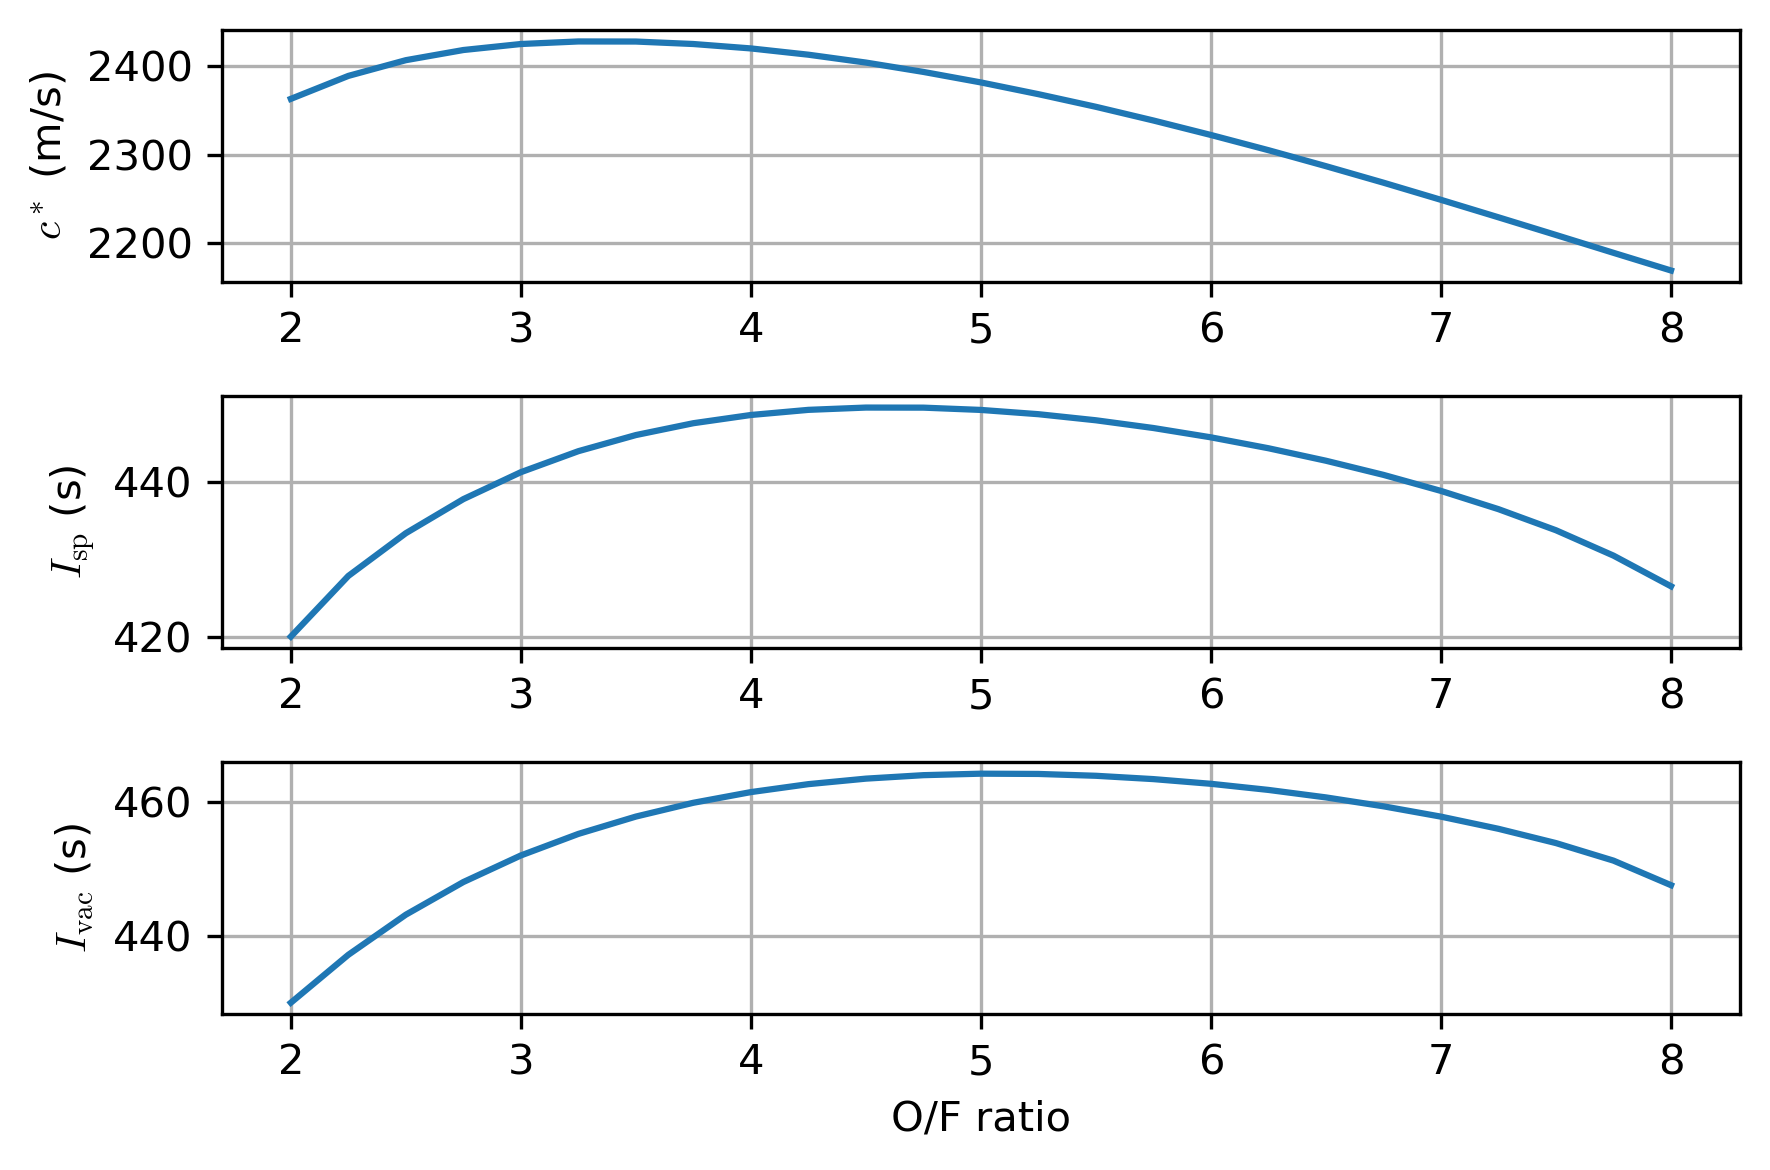

In [63]:
fig, axes = plt.subplots(3, 1)

axes[0].plot(mixture_ratios, to_si(cstars))
axes[0].set_ylabel('$c^*$ (m/s)')
axes[0].grid(True)

axes[1].plot(mixture_ratios, to_si(specific_impulses))
axes[1].set_ylabel('$I_{\mathrm{sp}}$ (s)')
axes[1].grid(True)

axes[2].plot(mixture_ratios, to_si(specific_impulses_vac))
axes[2].set_xlabel('O/F ratio')
axes[2].set_ylabel('$I_{\mathrm{vac}}$ (s)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

This allows us to determine the mixture ratio for optimal performance, although in practice something slightly off-optimal might be used for other reasons (e.g., combustion stability, reducing peak temperature).

## Frozen vs. shifting equilibrium

We have already seen how assuming the mixture composition either remains frozen from the combustion chamber or follows a shifting equilibrium model leads to different calculations of performance. 
Frozen equilibrium underpredicts, while shifting equilibrium overpredicts.
We can use these together to estimate the true actual performance as somewhere in between, such as 40% of the difference between the two results.

We already have results for shifting equilibrum, and can similarly extract the specific impulse for frozen equilibrium calculations saved in `CEA_OF_ratio_frozen_out.txt`:

In [6]:
# Click the + to see the full contents of the output file
filename = 'CEA_OF_ratio_frozen_out.txt'
print('Contents of ' + filename + ':')
with open(filename) as f:
    file_contents = f.read()
    print(file_contents)

Contents of CEA_OF_ratio_frozen_out.txt:


         NASA-GLENN CHEMICAL EQUILIBRIUM PROGRAM CEA2, FEBRUARY 5, 2004
                   BY  BONNIE MCBRIDE AND SANFORD GORDON
      REFS: NASA RP-1311, PART I, 1994 AND NASA RP-1311, PART II, 1996

 *******************************************************************************

  
 ### CEA analysis performed on Tue 08-Feb-2022 17:38:43
  
 # Problem Type: "Rocket" (Infinite Area Combustor)
  
 prob case=_______________8942 ro frozen
  
 # Pressure (1 value):
 p,psia= 2870
 # Supersonic Area Ratio (1 value):
 supar= 68.8
  
 # Oxidizer/Fuel Wt. ratio (25 values):
 o/f= 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5
 .75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8
  
 # You selected the following fuels and oxidizers:
 reac
 fuel H2(L)             wt%=100.0000
 oxid O2(L)             wt%=100.0000
  
 # You selected these options for output:
 # short version of output
 output short
 # Proportions of any products wil

In [64]:
with open('CEA_OF_ratio_frozen_out.txt', 'r') as f:
    lines = f.readlines()

specific_impulses_frozen = []

for line in lines:
    # ignore blank lines
    if not line.strip():
        continue
    
    words = line.split()
    if words[0] == 'Isp,':
        specific_impulses_frozen.append(float(words[3]))
specific_impulses_frozen = Q_(np.array(specific_impulses_frozen), 'm/s') / g0

# just checking that things line up
assert len(mixture_ratios) == len(specific_impulses_frozen)

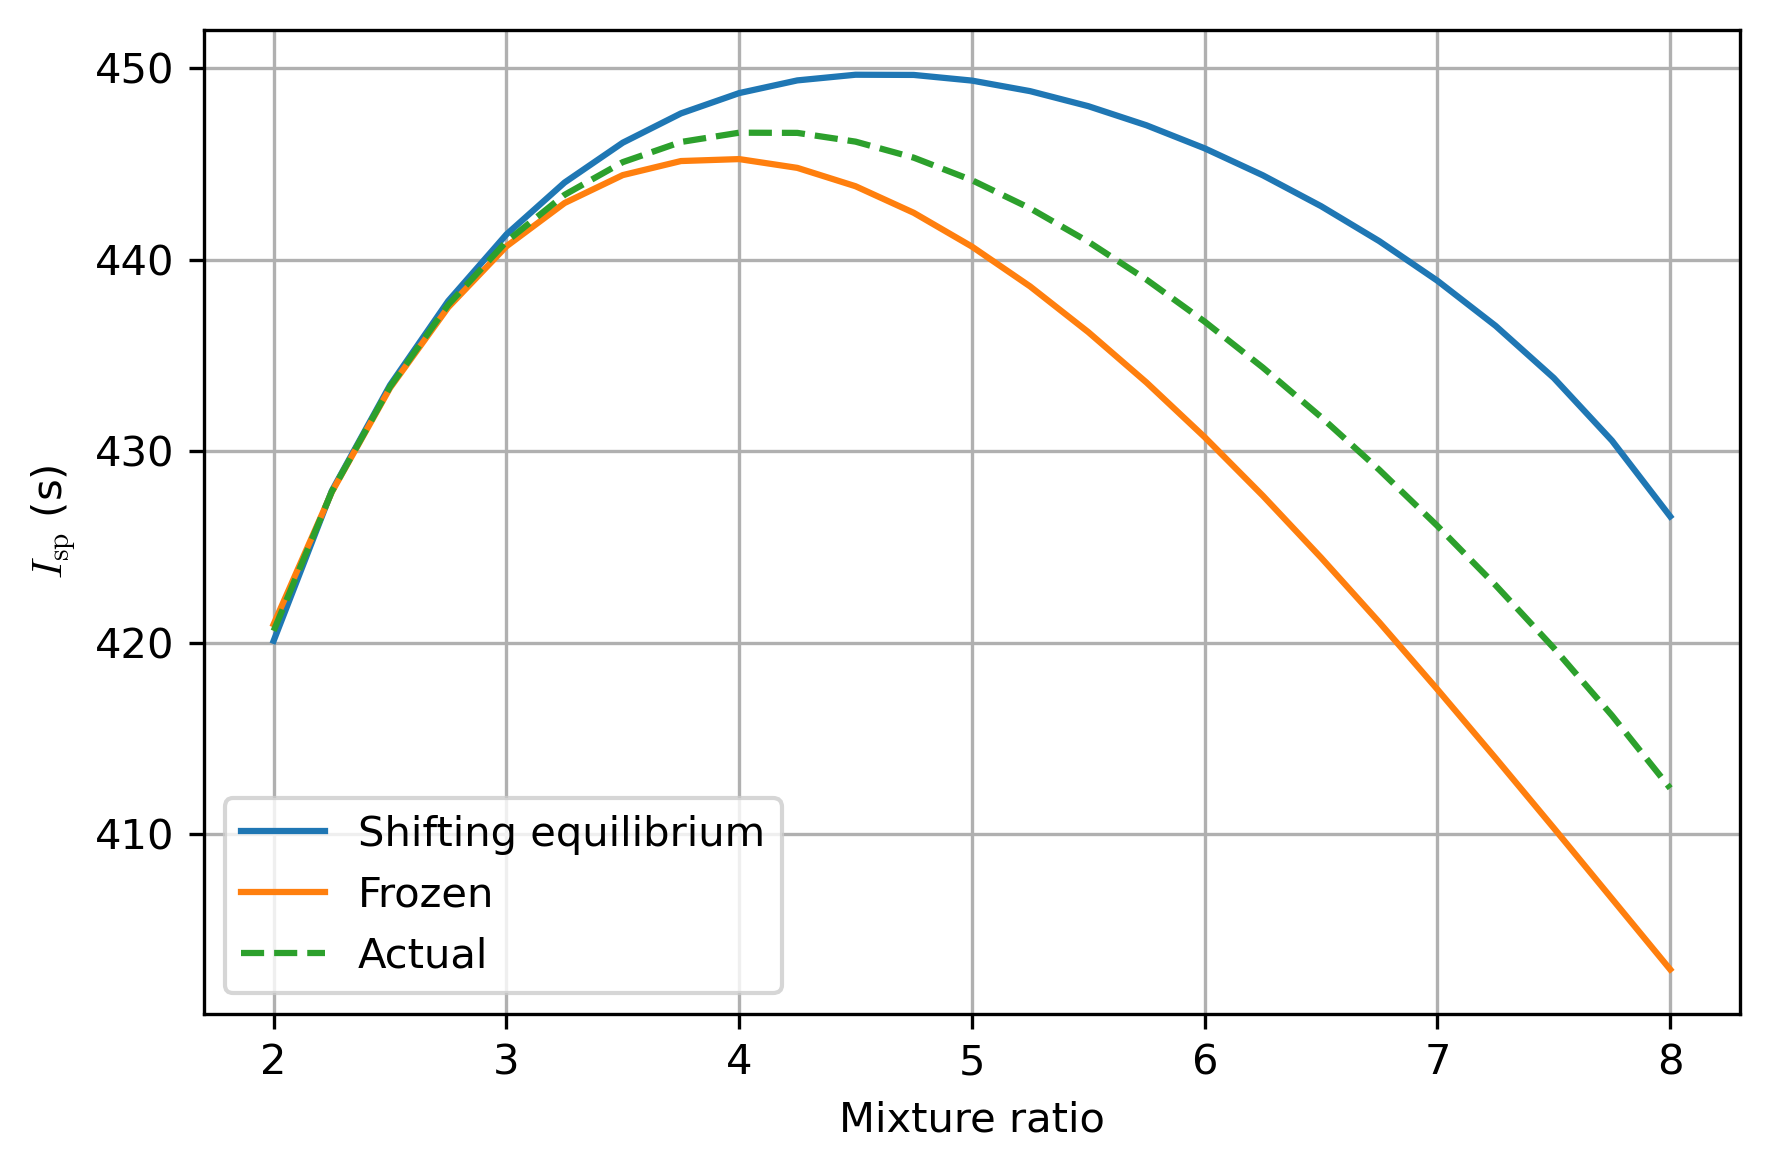

In [67]:
specific_impulses_act = specific_impulses_frozen + 0.4*(specific_impulses - specific_impulses_frozen)

plt.plot(mixture_ratios, to_si(specific_impulses), label='Shifting equilibrium')
plt.plot(mixture_ratios, to_si(specific_impulses_frozen), label='Frozen')
plt.plot(mixture_ratios, to_si(specific_impulses_act), '--', label='Actual')
plt.ylabel('$I_{\mathrm{sp}}$ (s)')
plt.xlabel('Mixture ratio')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()